In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import models, transforms
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
import os
import glob
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lectura de clases y anotaciones
Se leen las clases desde `classes.txt` y los archivos `annotation.txt` para crear los DataFrames de entrenamiento y prueba.

In [5]:
BASE = "/content/drive/MyDrive/Maestría Eafit/3er Semestre/Visión por computador/Talleres/data/LabelMe-12-50k"
TRAIN_DIR = os.path.join(BASE, "train")
TEST_DIR  = os.path.join(BASE, "test")
CLASSES_FILE = os.path.join(BASE, "classes.txt")
TRAIN_ANNOT = os.path.join(TRAIN_DIR, "annotation.txt")
TEST_ANNOT  = os.path.join(TEST_DIR,  "annotation.txt")



with open(CLASSES_FILE, 'r', encoding='utf-8') as f:
    classes = [line.strip() for line in f if line.strip()]
print("Clases:", classes)
n_classes = len(classes)

Clases: ['person', 'car', 'building', 'window', 'tree', 'sign', 'door', 'bookshelf', 'chair', 'table', 'keyboard', 'head']


In [6]:
def read_annotation(annot_path):

    df = pd.read_csv(annot_path, sep=r"\s+", header=None)

    expected_cols = 1 + n_classes
    if df.shape[1] < expected_cols:
        raise ValueError(f"El archivo {annot_path} tiene menos columnas ({df.shape[1]}) que clases+id ({expected_cols}).")

    df = df.iloc[:, :expected_cols]
    df.columns = ["image_id"] + classes

    for c in classes:
        df[c] = df[c].replace(-1, 0).replace(-1.0, 0).fillna(0).astype(int)

    df["image_name"] = df["image_id"].astype(str).str.zfill(6) + ".jpg"
    return df

train_df = read_annotation(TRAIN_ANNOT)
print("Train filas:", len(train_df))

Train filas: 40000


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
if os.path.exists(TEST_ANNOT):
    test_df = read_annotation(TEST_ANNOT)
    print("Test filas:", len(test_df))
else:
    test_df = None
    print("No se encontró annotation.txt en test. Usa solo train o crea test_df manualmente.")


Test filas: 10000


In [9]:
def build_path_map(base_dir):
    paths = glob.glob(os.path.join(base_dir, "*", "*.jpg"))
    mapa = { os.path.basename(p).split('.')[0] : p for p in paths }
    return mapa

train_map = build_path_map(TRAIN_DIR)
test_map = build_path_map(TEST_DIR) if os.path.exists(TEST_DIR) else {}


In [10]:
train_df["path"] = train_df["image_name"].str.replace(".jpg","").map(train_map)
if test_df is not None:
    test_df["path"] = test_df["image_name"].str.replace(".jpg","").map(test_map)

miss_train = train_df['path'].isna().sum()
print(f"Imágenes faltantes en train (sin path detectado): {miss_train}")
if test_df is not None:
    print("Imágenes faltantes en test:", test_df['path'].isna().sum())

# Opcional: eliminar filas sin path (si prefieres)
train_df = train_df.dropna(subset=["path"]).reset_index(drop=True)
if test_df is not None:
    test_df = test_df.dropna(subset=["path"]).reset_index(drop=True)

Imágenes faltantes en train (sin path detectado): 0
Imágenes faltantes en test: 0


Total de imágenes de entrenamiento: 40000
Total de imágenes de prueba: 10000


/tmp/ipython-input-1973499163.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")


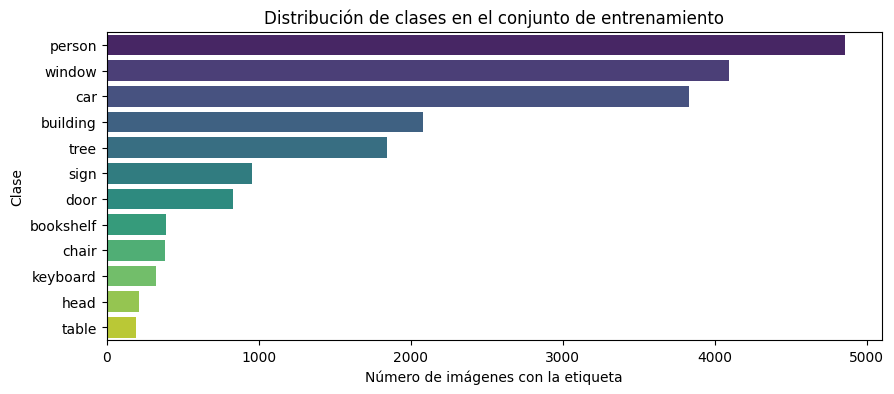

In [11]:
print(f"Total de imágenes de entrenamiento: {len(train_df)}")
if test_df is not None:
    print(f"Total de imágenes de prueba: {len(test_df)}")

# %%
# 🔹 Conteo de imágenes por clase
label_counts = train_df[classes].sum().sort_values(ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Número de imágenes con la etiqueta")
plt.ylabel("Clase")
plt.show()


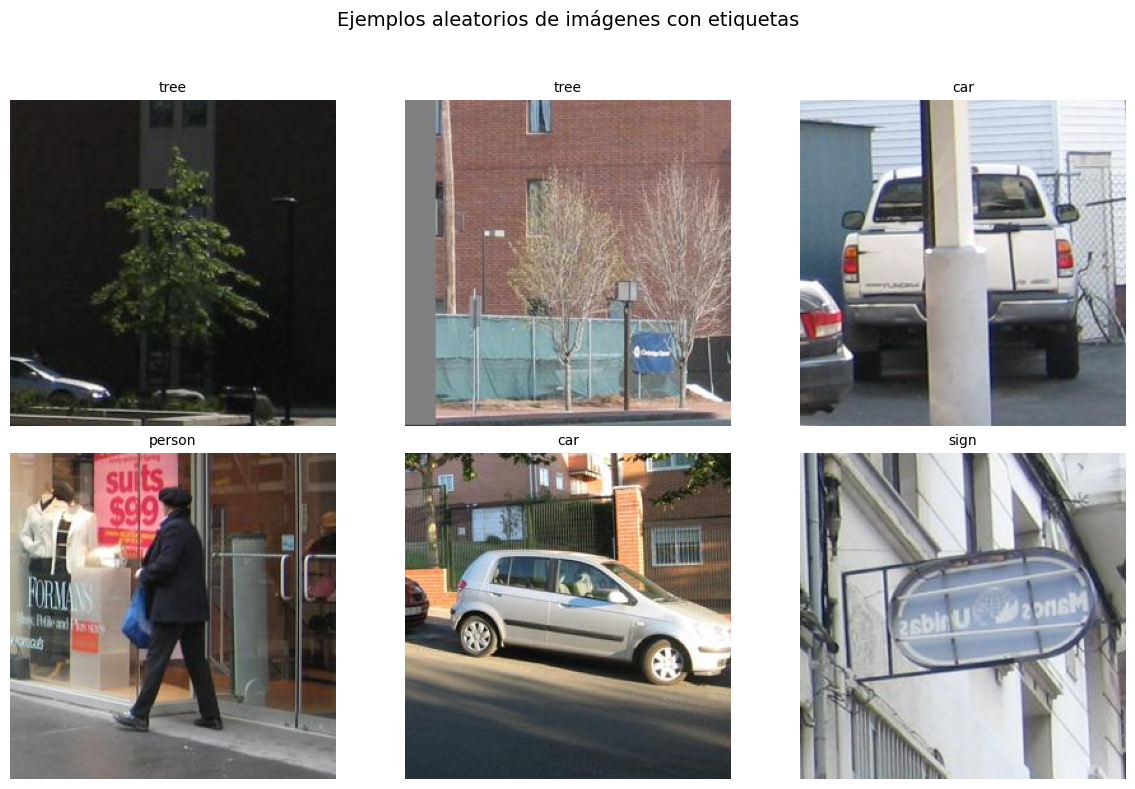

In [12]:

sample_df = train_df[train_df[classes].sum(axis=1) > 0].sample(6, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (_, row) in enumerate(sample_df.iterrows()):
    img = Image.open(row["path"])
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    etiquetas_presentes = [c for c in classes if row[c] == 1]
    ax.set_title(", ".join(etiquetas_presentes), fontsize=10)
    ax.axis("off")

plt.suptitle("Ejemplos aleatorios de imágenes con etiquetas", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Extracción de características con ResNet50
Se utiliza un modelo **ResNet50 preentrenado** para obtener representaciones vectoriales de cada imagen

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

resnet = models.resnet50(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

def extract_features_from_df(df):
    X_list = []
    for p in tqdm(df["path"].values, desc="Extrayendo features"):
        try:
            img = Image.open(p).convert("RGB")
            t = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = feature_extractor(t).cpu().numpy().reshape(-1)  # 2048-d
            X_list.append(feat)
        except Exception as e:
            # En caso de error, agregar vector cero (opcional)
            print("Error leyendo", p, e)
            X_list.append(np.zeros(2048, dtype=np.float32))
    X = np.vstack(X_list)
    return X


Usando device: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


In [14]:
X_train = extract_features_from_df(train_df)
y_train = train_df[classes].values


print("Shapes X_train, y_train:", X_train.shape, y_train.shape)


Extrayendo features: 100%|██████████| 40000/40000 [5:17:05<00:00,  2.10it/s]


Shapes X_train, y_train: (40000, 2048) (40000, 12)


In [15]:
X_test = extract_features_from_df(test_df)
y_test = test_df[classes].values

np.save("X_test_feats.npy", X_train)
np.save("y_test_labels.npy", y_train)

Extrayendo features: 100%|██████████| 10000/10000 [1:20:24<00:00,  2.07it/s]


In [16]:
np.save("X_train_feats.npy", X_train)
np.save("y_train_labels.npy", y_train)

In [17]:
X_train = np.load("X_train_feats.npy")
y_train = np.load("y_train_labels.npy")

In [18]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train).astype(int)


In [19]:
if X_train is not None:
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train).astype(int)

assert not np.isnan(X_train).any(), "NaNs en X_train"
assert not np.isnan(y_train).any(), "NaNs en y_train"
if X_train is not None:
    assert not np.isnan(X_train).any(), "NaNs en X_test"
    assert not np.isnan(y_train).any(), "NaNs en y_test"

# Verificar dimensiones coincidentes
assert X_train.shape[0] == y_train.shape[0], "Nº filas X_train != y_train"


# Entrenamiento del modelo XGBoost (MultiOutput)

Se entrena un modelo **XGBoost** para clasificación multi-etiqueta utilizando `MultiOutputClassifier`.


In [20]:
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split




base = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,

    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

clf = MultiOutputClassifier(base, n_jobs=-1)

print("Entrenando modelo multi-output (esto puede tardar)...")
clf.fit(X_train, y_train)
print("Entrenamiento completado.")


Entrenando modelo multi-output (esto puede tardar)...
Entrenamiento completado.


In [21]:

import joblib
joblib.dump(clf, "modelo_xgb_multioutput.pkl")

['modelo_xgb_multioutput.pkl']

#  Evaluación del modelo
Se calculan métricas de desempeño globales y por clase

In [22]:
from sklearn.metrics import f1_score, classification_report

if X_test is not None:
    print("Evaluando modelo en el conjunto de prueba...")
    y_pred = clf.predict(X_test)

    # Métricas globales
    print("\n🔹 F1-score (micro):", f1_score(y_test, y_pred, average="micro"))
    print("🔹 F1-score (macro):", f1_score(y_test, y_pred, average="macro"))

    # Métricas por clase
    print("\n📊 Reporte por clase:")
    print(classification_report(y_test, y_pred, target_names=classes))
else:
    print("⚠️ No se proporcionó annotation.txt en test; sólo se entrenó con train.")


Evaluando modelo en el conjunto de prueba...

🔹 F1-score (micro): 0.8070743017362234
🔹 F1-score (macro): 0.6918458094134866

📊 Reporte por clase:
              precision    recall  f1-score   support

      person       0.92      0.87      0.90      1180
         car       0.91      0.92      0.91       974
    building       0.75      0.45      0.56       531
      window       0.90      0.82      0.86      1028
        tree       0.80      0.64      0.71       494
        sign       0.78      0.50      0.61       249
        door       0.75      0.36      0.49       178
   bookshelf       0.89      0.70      0.78       100
       chair       0.72      0.52      0.61        88
       table       0.86      0.11      0.20        54
    keyboard       0.89      0.96      0.92        75
        head       0.83      0.69      0.76        49

   micro avg       0.88      0.75      0.81      5000
   macro avg       0.83      0.63      0.69      5000
weighted avg       0.86      0.75      0.7

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


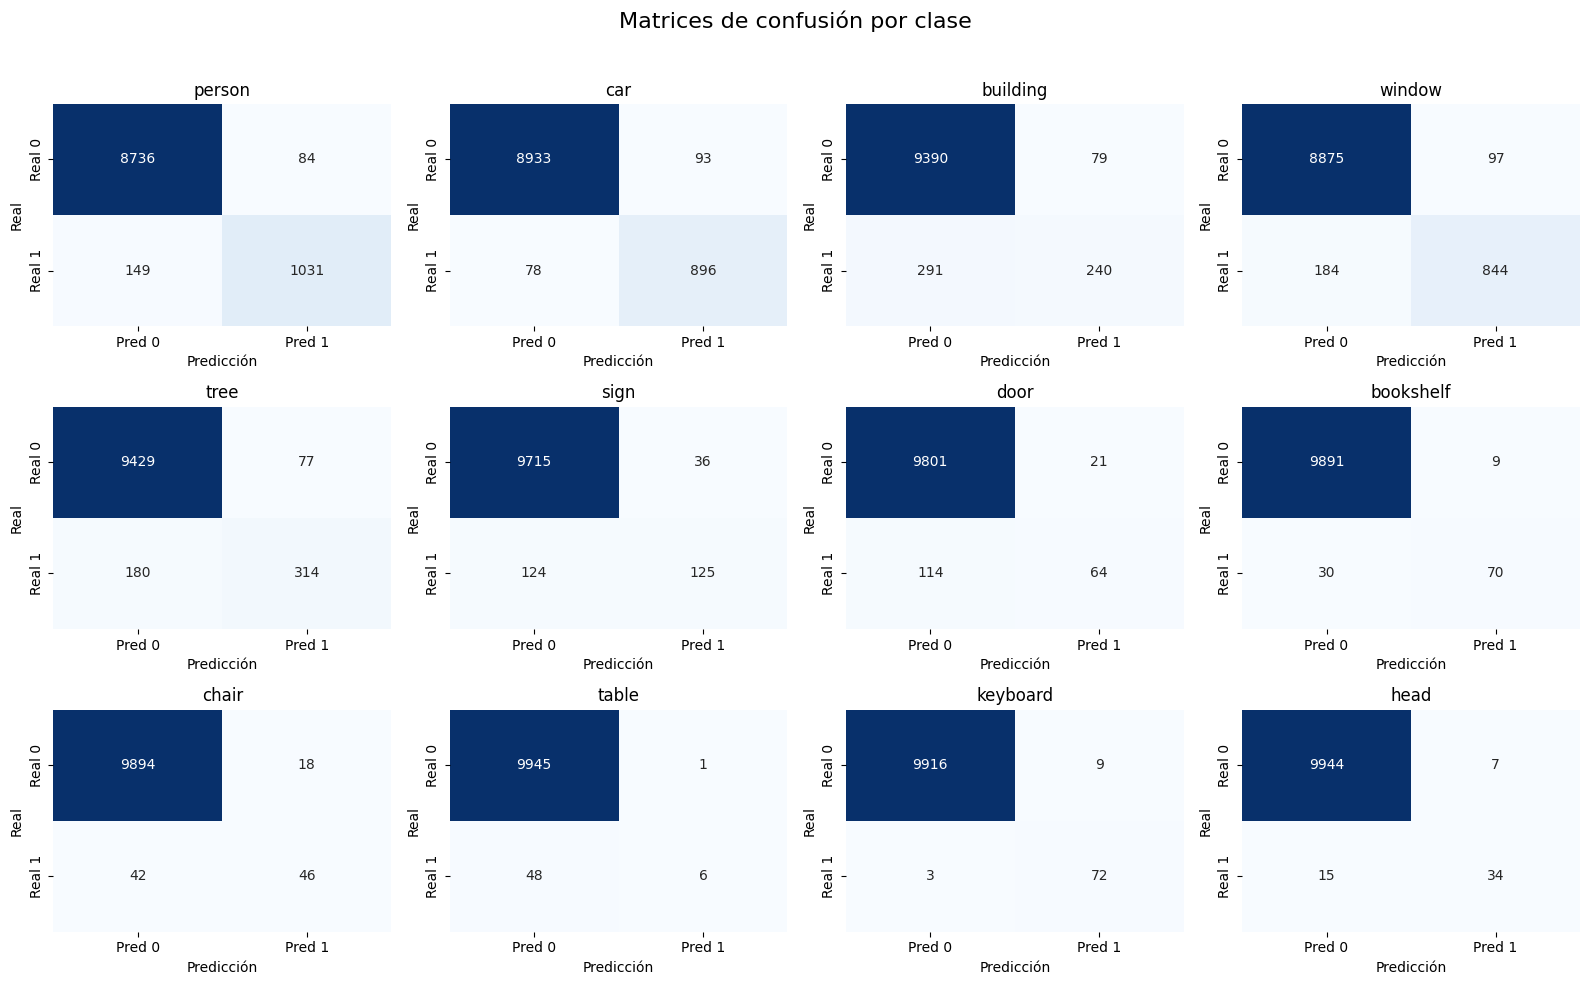

In [23]:


n_classes = len(classes)
n_cols = 4
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10))
axes = axes.flatten()

for i, label in enumerate(classes):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False,
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Real 0", "Real 1"],
        ax=axes[i]
    )
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Matrices de confusión por clase", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

